In [20]:
# Lecture 5. Most of the code here will be in nn.ipynb

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_images = datasets.MNIST('data', train=True, download=True)
mnist_data = datasets.MNIST('data', train=True, 
                            transform=transforms.ToTensor())
mnist_data = list(mnist_data)

mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

In [28]:
# From nn.ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, num_hidden):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(28 * 28, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 1)
        self.num_hidden = num_hidden
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)   # reshaping `img` to [-1, 784]
        activation1 = self.layer1(flattened) # computing the activation
                                             # of neurons in the next layer
        # activation1.shape  [1, 30]
        activation1 = F.relu(activation1) # applying RELU nonlinearity
        # activation1.shape  [1, 30]
        activation2 = self.layer2(activation1) # computing the activation
                                               # of neurons in the output 
                                               # layer
        # activation2.shape  [1, 1]
        return activation2

model = Model(30)

In [41]:
model(img)

tensor([[0.1105]], grad_fn=<ThAddmmBackward>)

In [42]:
model(img).shape

torch.Size([1, 1])

In [29]:
model.parameters() # from the nn.Module class

<generator object Module.parameters at 0x11ab70468>

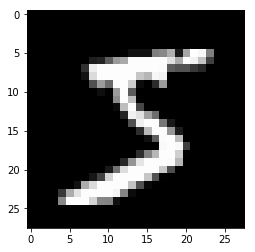

In [32]:
plt.imshow(mnist_images[0][0])

In [30]:
img, label = mnist_data[0]

In [33]:
img.shape

torch.Size([1, 28, 28])

In [34]:
model(img)

tensor([[0.1105]], grad_fn=<ThAddmmBackward>)

In [35]:
fc = nn.Linear(28*28, 100)

In [37]:
flattened = img.view(-1, 28 * 28)
flattened.shape

torch.Size([1, 784])

In [38]:
fc(flattened).shape

torch.Size([1, 100])

In [39]:
for p in fc.parameters():
    print(p.shape)

torch.Size([100, 784])
torch.Size([100])


In [40]:
img.shape

torch.Size([1, 28, 28])

In [43]:
model(img).shape

torch.Size([1, 1])

In [49]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 30)
        self.layer3 = nn.Linear(30, 10)
    def forward(self, img):
        flatten = img.view(-1, 28*28)
        # compute activation for first hidden layer
        a1 = F.relu(self.layer1(flatten))
        a2 = F.relu(self.layer2(a1)) # second hidden layer
        return self.layer3(a2) # output layer

In [50]:
classifier = MNISTClassifier()

In [54]:
output = classifier(img)

In [55]:
output

tensor([[ 0.1074, -0.0451, -0.0397, -0.1831, -0.0099, -0.1432,  0.1740, -0.0183,
         -0.1693, -0.1052]], grad_fn=<ThAddmmBackward>)

In [57]:
output.shape

torch.Size([1, 10])

In [56]:
prob = F.softmax(output, dim=1)
prob

tensor([[0.1155, 0.0992, 0.0997, 0.0864, 0.1028, 0.0899, 0.1235, 0.1019, 0.0876,
         0.0934]], grad_fn=<SoftmaxBackward>)

In [58]:
F.softmax(output, dim=0)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<SoftmaxBackward>)

In [59]:
# train this model
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)

criterion = nn.CrossEntropyLoss() 
# because we are no longer doing a binary clasisfication problem

optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

In [63]:
for epoch in range(30):
    for imgs, labels in iter(train_loader):
        out = classifier(imgs) # compute prediction -- forward pass
        loss = criterion(out, labels) # compute loss
        loss.backward()   # backward pass (computer param updates)
        optimizer.step()
        optimizer.zero_grad() # normally at the beginning of an iter   

In [70]:
# From nn.ipynb

train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=4096)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1024)

def get_accuracy(model, train=False):
    if train:
        data = mnist_train[:64]
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total



def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            optimizer.zero_grad()         # a clean up step for PyTorch

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))

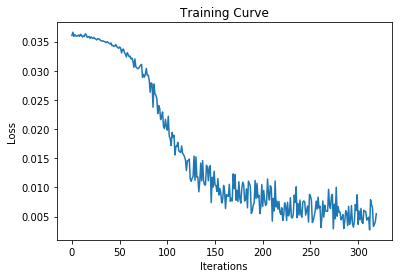

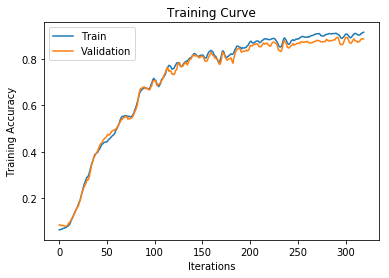

Final Training Accuracy: 0.914306640625
Final Validation Accuracy: 0.8857421875


In [65]:
model = MNISTClassifier()
train(model, mnist_train, num_epochs=5)

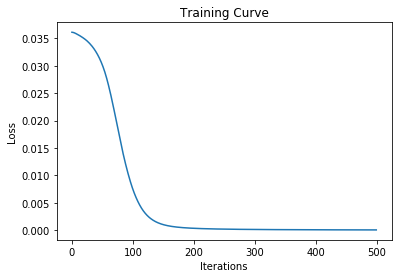

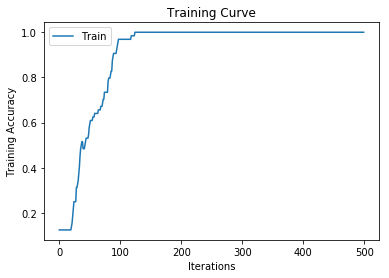

In [71]:
mnist_overfit = mnist_train[:64]
model = MNISTClassifier()
train(model, mnist_overfit, num_epochs=500)

In [73]:
x = torch.tensor([[1., 1.],
                 [3., 4.],
                 [2., 2.]])

In [74]:
x.shape

torch.Size([3, 2])

In [75]:
F.softmax(x, dim=0)

tensor([[0.0900, 0.0420],
        [0.6652, 0.8438],
        [0.2447, 0.1142]])

In [76]:
F.softmax(x, dim=1)

tensor([[0.5000, 0.5000],
        [0.2689, 0.7311],
        [0.5000, 0.5000]])